In [76]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore')

In [77]:
# Pyspark - SQL
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import mean, col, split, regexp_extract, when, lit

# Pyspark - ML
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

### 데이터 로드

- Pyspark에서 데이터 로드할 때는 ``os.chdir()``로 디렉토리명 바꾸어도 적용이 안됨!

In [79]:
spark = SparkSession.builder\
        .appName('Play with pypsark ML on Titanic Data')\
        .getOrCreate()
df = spark.read.csv('/Users/younghun/Desktop/gitrepo/data/titanic/train.csv', header=True, inferSchema=True)

In [80]:
# toPandas()를 이용해 판다스에서 제공하는 데이터프레임 형태로 출력
df.limit(num=3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S


In [81]:
# 데이터 스키마 살펴보기
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



### 데이터 시각화
- Matplotlib, Seaborn 등을 이용하려면 ``SparkDataFrame``➡️``PandasDataFrame``으로 변경해주고 수행해야 함!

pandas_df 타입: <class 'pandas.core.frame.DataFrame'>


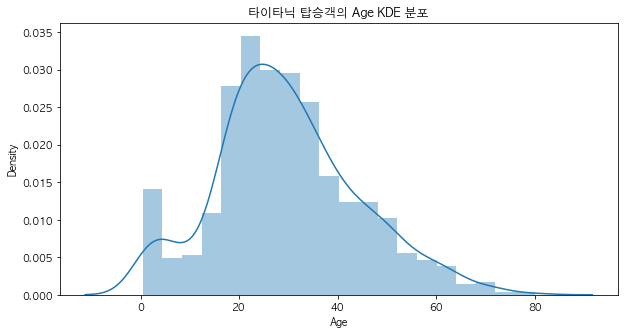

In [82]:
pandas_df = df.toPandas()
print("pandas_df 타입:", type(pandas_df))

# Seaborn 사용해보기
plt.figure(figsize=(10, 5))
plt.title("타이타닉 탑승객의 Age KDE 분포")
sns.distplot(pandas_df['Age'])
plt.show()

### Pyspark에서 결측치 체크하기

- 결측치 체크하는 방법
    * 1. ``isnan()``: ``pyspark.sql.functions`` 패키지에 속함
        * ``isnan(column)``: 결측치가 존재하는 변수인지 체크하기 위함
    * 2. ``isNull()``: ``pyspark.sql.Column`` 패키지에 속함
        * ``isNull()``은 아무런 변수 넣지 않음
<br><br>
- ``when(조건, 조건 True시 value출력).otherwise(앞의 조건 False시 value출력)``
    * 조건에 여러 조건을 달려면 논리연산자 ``|``, ``&`` 사용 가능

In [83]:
# 위 2가지 방법을 동시에 사용해보자!
# 결측치가 있는 변수를 체크하고 결측치가 몇 개 있는지 살펴보기
from pyspark.sql.functions import isnan, count

# [count~] 부분은 list comprehension이면서 select([column]) 부분임!
# [count(~~) 변수를 'c'라는 변수로 alias하는 것임!] 
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])\
  .show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



- 변수 삭제하는 법
    * ``df.drop('column')`` 단, inplace=False이기 때문에 재할당 해주어야 함!

In [84]:
# Cabin 변수는 결측치가 50%가 넘기 때문에 해당 변수를 삭제하자
df = df.drop('Cabin')

- 연령의 결측치 대체하기
- 그런데, 승객들의 이름 앞에 ``Mr, Mrs``와 같은 salutation들이 존재하므로 이것을 기준으로 분할하고 각각의 평균값을 결측치 대체값으로 넣어주기
- Pyspark에서 제공하는 정규표현식 API 이용
    * ``regexp_extract(col('칼럼'), "정규표현식",

In [85]:
df = df.withColumn("Initial", regexp_extract(col("Name"),
                                            "([A-Za-z]+)\.", # ()이게 하나의 그룹임!
                                            1)) # 그룹 인덱스는 1부터!
df.limit(3).show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Embarked|Initial|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|       S|     Mr|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|       C|    Mrs|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|       S|   Miss|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+-------+



- 오탈자 대체하기
    * ``df.replace([오탈자], [수정된 글자])``

- ``collect()``: 적은 양의 데이터셋을 retrieve할 때!(큰 데이터셋은 메모리 에러 발생). ``select()``와 유사한 기능
    * 보통 ``filter()``, ``group()``, ``count()`` 후 사용
    * ``collect()``로 아무것도 넣지않으면 데이터프레임의 모든 row를 반환
    * 하지만 dataframe형태로 반환하지 않음. , pyspark Row타입의 데이터가 담긴 list를 반환하는데 이를 loop 사용가능함!

In [86]:
df = df.replace(['Mlle','Mme', 'Ms', 'Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                ['Miss','Miss','Miss','Mr','Mr',  'Mrs',  'Mrs',  'Other',  'Other','Other','Mr','Mr','Mr'])

# Initial 변수 값들로 그룹핑한 후 평균 Age 구하기
df.groupby('Initial').avg('Age').collect()

[Row(Initial='Miss', avg(Age)=21.86),
 Row(Initial='Other', avg(Age)=45.888888888888886),
 Row(Initial='Master', avg(Age)=4.574166666666667),
 Row(Initial='Mr', avg(Age)=32.73960880195599),
 Row(Initial='Mrs', avg(Age)=35.981818181818184)]

In [87]:
test = df.groupby('Initial').avg('Age').collect()
print(type(test), type(test[0]))

<class 'list'> <class 'pyspark.sql.types.Row'>


### Pyspark에서 결측치 대체
- 위에서 도출한 연령별 평균값을 대체하기

In [88]:
df = df.withColumn('Age',
                  when((df['Initial'] == 'Miss') & (df['Age'].isNull()),
                      22).otherwise(df['Age']))
df = df.withColumn('Age',
                  when((df['Initial'] == 'Other') & (df['Age'].isNull()),
                      46).otherwise(df['Age']))
df = df.withColumn('Age',
                  when((df['Initial'] == 'Master') & (df['Age'].isNull()),
                      5).otherwise(df['Age']))
df = df.withColumn('Age',
                  when((df['Initial'] == 'Mr') & (df['Age'].isNull()),
                      33).otherwise(df['Age']))
df = df.withColumn('Age',
                  when((df['Initial'] == 'Mrs') & (df['Age'].isNull()),
                      36).otherwise(df['Age']))

In [89]:
# Embarked 변수에도 결측치가 2개 있었는데 무엇인지 확인해보기
df.groupBy('Embarked').count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    null|    2|
|       C|  168|
|       S|  644|
+--------+-----+



- PysparkDataFrame의 결측치 채우는 함수
    * ``df.na.fill({'column': 'value'})``

In [90]:
# Embarked의 결측치는 최빈값인 'S'로 대체해주기
df = df.na.fill({"Embarked": "S"})

In [91]:
df.groupBy('Embarked').count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|       C|  168|
|       S|  646|
+--------+-----+



In [92]:
# 결측치가 있는 변수가 있는지 재확인!
df.select([count(when(isnan(c) | df[c].isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Embarked|Initial|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|       0|      0|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+



### Feature Engineering
- Pyspark의 ``withColumn``, ``when ~ otherwise``주로 사용!
- 변수 추출하는 동일한 표현: ``df['SibSp'] = col('SibSp')``

In [93]:
# Family size라는 파생변수 생성
df = df.withColumn("Family_Size",
                  col('SibSp')+col('Parch')) # df['SibSp']도 가능!

# Alone이라는 Binary 파생변수 생성하는데, 우선 0으로 다 해놓기
df = df.withColumn('Alone', lit(0))
# 조건에 맞게 Alone 변수값 변경
df = df.withColumn('Alone',
                  when(col('Family_Size') == 0, 1)\
                  .otherwise(col('Alone')))

- 문자열로 이루어져있는 Sex, Embarked, Initial을 숫자로 바꾸어주기(일종의 **Label Encoding**)
    * ``StringIndexer(inputCol, outputCol)`` 사용!
    * ``fit(df)``한 객체에서 역으로 IndexToString 사용가능하니 fit, transform 따로 할당해주기!
    * ``transform(df)``

In [94]:
convert_cols = ['Sex', 'Embarked', 'Initial']

# 추후에 IndexToString할려면 indexer 객체를 사용하면 됨! 
indexer = [StringIndexer(inputCol=col,
                         outputCol=col+'_index').fit(df) for col in convert_cols]
for i in indexer:
    print(i)
    print('-'*80)
    
print(type(indexer))

StringIndexerModel: uid=StringIndexer_bb1ea92802a9, handleInvalid=error
--------------------------------------------------------------------------------
StringIndexerModel: uid=StringIndexer_81e8ee1eb63a, handleInvalid=error
--------------------------------------------------------------------------------
StringIndexerModel: uid=StringIndexer_fa10a2871e0e, handleInvalid=error
--------------------------------------------------------------------------------
<class 'list'>


In [95]:
# Pipeline을 이용해 stage에다가 실행 과정 담아 넘기기
pipeline = Pipeline(stages=indexer)
df = pipeline.fit(df).transform(df)
df.limit(3).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial,Family_Size,Alone,Sex_index,Embarked_index,Initial_index
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,1,0,0.0,0.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,1,0,1.0,1.0,2.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,0,1,1.0,0.0,1.0


In [96]:
pandas_df = df.toPandas()
pandas_df['Initial_index'].value_counts()

0.0    529
1.0    186
2.0    127
3.0     40
4.0      9
Name: Initial_index, dtype: int64

- 모델링에 필요없는 변수들 삭제
    * 직접 변수들 정의하는 방식: ``df.drop('col1', 'col2', col3')
    * ``*``(unpacking)을 이용하는 방식도 존재!

In [98]:
un_cols = ["PassengerId","Name","Ticket","Cabin","Embarked","Sex","Initial"]

df = df.drop(*un_cols)
print("삭제 후 남은 칼럼들:", df.columns)

삭제 후 남은 칼럼들: ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Family_Size', 'Alone', 'Sex_index', 'Embarked_index', 'Initial_index']


### Convert all features to Vector

- ``VectorAssembler(inputCols, outputCol)``
    * ``StringIndexer``와는 달리 ``inputCol``에 ``s``가 붙어있음!
    * fit 존재하지 않고 바로 ``transform(df)`` 수행!

In [99]:
feature = VectorAssembler(inputCols = df.columns[1:],
                         outputCol='features')
feature_vector = feature.transform(df) # 데이터프레임 형태로 반환
print('feature type:', type(feature))
print('feature_vector type', type(feature_vector))

feature_vector.limit(10).toPandas()

feature type: <class 'pyspark.ml.feature.VectorAssembler'>
feature_vector type <class 'pyspark.sql.dataframe.DataFrame'>


,Survived,Pclass,Age,SibSp,Parch,Fare,Family_Size,Alone,Sex_index,Embarked_index,Initial_index,features
0,0,3,22.0,1,0,7.2500,1,0,0.0,0.0,0.0,"(3.0, 22.0, 1.0, 0.0, 7.25, 1.0, 0.0, 0.0, 0.0..."
1,1,1,38.0,1,0,71.2833,1,0,1.0,1.0,2.0,"[1.0, 38.0, 1.0, 0.0, 71.2833, 1.0, 0.0, 1.0, ..."
2,1,3,26.0,0,0,7.9250,0,1,1.0,0.0,1.0,"[3.0, 26.0, 0.0, 0.0, 7.925, 0.0, 1.0, 1.0, 0...."
3,1,1,35.0,1,0,53.1000,1,0,1.0,0.0,2.0,"[1.0, 35.0, 1.0, 0.0, 53.1, 1.0, 0.0, 1.0, 0.0..."
4,0,3,35.0,0,0,8.0500,0,1,0.0,0.0,0.0,"(3.0, 35.0, 0.0, 0.0, 8.05, 0.0, 1.0, 0.0, 0.0..."
5,0,3,33.0,0,0,8.4583,0,1,0.0,2.0,0.0,"(3.0, 33.0, 0.0, 0.0, 8.4583, 0.0, 1.0, 0.0, 2..."
6,0,1,54.0,0,0,51.8625,0,1,0.0,0.0,0.0,"(1.0, 54.0, 0.0, 0.0, 51.8625, 0.0, 1.0, 0.0, ..."
7,0,3,2.0,3,1,21.0750,4,0,0.0,0.0,3.0,"[3.0, 2.0, 3.0, 1.0, 21.075, 4.0, 0.0, 0.0, 0...."
8,1,3,27.0,0,2,11.1333,2,0,1.0,0.0,2.0,"[3.0, 27.0, 0.0, 2.0, 11.1333, 2.0, 0.0, 1.0, ..."
9,1,2,14.0,1,0,30.0708,1,0,1.0,1.0,2.0,"[2.0, 14.0, 1.0, 0.0, 30.0708, 1.0, 0.0, 1.0, ..."


### Split the datasets

- ``df.randomSplit([train_ratio, test_ratio])``
- split할 때는 ``VectorAssembler`` 시키기 이전의 다른 Raw 피처들도 함께 분할하긴 함. 하지만 **모델링 시 사용할 때는 벡터화 시킨 독립변수들과 종속변수만 사용!**

In [100]:
(train_df, test_df) = feature_vector.randomSplit([0.8, 0.2], seed=42)
train_df.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Family_Size: integer (nullable = true)
 |-- Alone: integer (nullable = false)
 |-- Sex_index: double (nullable = false)
 |-- Embarked_index: double (nullable = false)
 |-- Initial_index: double (nullable = false)
 |-- features: vector (nullable = true)



### Modeling

- 독립변수, 종속변수만 담은 데이터프레임 따로 추출 후 다시 split

In [101]:
titanic_df = feature_vector.select(['features', 'Survived'])

# split train, test
(train_df, test_df) = titanic_df.randomSplit([0.8, 0.2], seed=42)

#### Logistic Regression

In [102]:
# 분류 모델 
from pyspark.ml.classification import LogisticRegression
# 파라미터 튜닝 & 교차 검증
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.tuning import CrossValidator
# 파이프라인
from pyspark.ml import Pipeline
# 메트릭 얻는 라이브러리
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# ROC AUC(Sklearn)
from sklearn.metrics import roc_curve, auc


# 모델 정의
lr = LogisticRegression(labelCol='Survived')

# 튜닝할 파라미터 grid 정의
                                    # model.parameter 식으로 정의
paramGrid = ParamGridBuilder().addGrid(lr.regParam,
                                      (0.01, 0.1))\
                              .addGrid(lr.maxIter,
                                      (5, 10))\
                              .addGrid(lr.tol,
                                      (1e-4, 1e-5))\
                              .addGrid(lr.elasticNetParam,
                                      (0.25, 0.75))\
                              .build()

# 교차검증 정의 - Pipeline식으로 정의
tvs = TrainValidationSplit(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol='Survived'),
                          trainRatio=0.8)
# 학습은 fit으로!
model = tvs.fit(train_df)
# 평가는 transform으로!
model_prediction = model.transform(test_df)

# 메트릭 평가
print('Accuracy:',
     MulticlassClassificationEvaluator(labelCol='Survived',
                                      metricName='accuracy').evaluate(model_prediction))
print('Precision:',
     MulticlassClassificationEvaluator(labelCol='Survived',
                                      metricName='weightedPrecision').evaluate(model_prediction))

Accuracy: 0.7793103448275862
Precision: 0.7925739676458068


- ``rawPrediction`` : 해당 feature를 Logistic Regression에 넣었을 때 계산되어 나오는 raw한 값
- ``probability``: ``rawPrediction``값에 Logistic 함수를 적용한 후 변환된 값. 즉, 0과 1사이의 확률값으로 매핑 됨
- ``prediction`` : ``probability``가 특정 임곗값 기준에 의해 1 또는 0으로 분류된 클래스(label)

In [103]:
model_prediction.show(10)

+--------------------+--------+--------------------+--------------------+----------+
|            features|Survived|       rawPrediction|         probability|prediction|
+--------------------+--------+--------------------+--------------------+----------+
|(10,[0,1,2,4,5],[...|       0|[0.84338731832489...|[0.69917814443410...|       0.0|
|(10,[0,1,2,4,5],[...|       0|[0.99789437623198...|[0.73064438650957...|       0.0|
|(10,[0,1,2,4,5],[...|       0|[1.03793833474865...|[0.73845201053973...|       0.0|
|(10,[0,1,2,4,5],[...|       0|[1.05840799891815...|[0.74238619430171...|       0.0|
|(10,[0,1,2,4,5],[...|       0|[1.71384782028168...|[0.84733469841398...|       0.0|
|(10,[0,1,2,4,5],[...|       0|[1.74541815045861...|[0.85137396441796...|       0.0|
|(10,[0,1,2,4,5],[...|       0|[2.26469777873056...|[0.90591081711254...|       0.0|
|(10,[0,1,2,4,5],[...|       0|[2.30965776946158...|[0.90967373903636...|       0.0|
|(10,[0,1,2,4,5],[...|       0|[2.29604033780988...|[0.9085485701

In [104]:
# Evaluate ROC metric
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark import SparkContext

# SparkContext를 만들기
sc = SparkContext.getOrCreate()

# ROC 점수인 AUC를 계산 위해 Logistic를 적용해 나온 확률값과 레이블만 가져오기
results = model_prediction.select(['probability', 'Survived'])

# 확률값 - 레이블 set 준비시키기
# collect()로 모든 데이터 row retrieve(반환) - 리스트 형태로 반환
results_collect = results.collect()

In [105]:
# named tuple 형식이기 때문에 key 값으로 원하는 값을 불러올 수 있다!
print(results_collect[0])
print()
print('probability:', results_collect[0].probability)
print('Survived:', results_collect[0].Survived)

Row(probability=DenseVector([0.6992, 0.3008]), Survived=0)

probability: [0.699178144434104,0.300821855565896]
Survived: 0


- 각 Row마다 다음의 값들을 추출
    * ``probability``에서 1이 될 확률
    * ``Survived(클래스값)``

In [50]:
results_list = [(float(i.probability[1]),
                 float(i.Survived)) for i in results_collect]
# 여러개의 튜플이 담긴 list를 RDD 자료구조로 변경
scoreAndLabels = sc.parallelize(results_list)
print(type(scoreAndLabels))
scoreAndLabels

<class 'pyspark.rdd.RDD'>


ParallelCollectionRDD[1057] at readRDDFromFile at PythonRDD.scala:262

In [51]:
# ROC metric 계산하기
metrics = metric(scoreAndLabels)
auc = metrics.areaUnderROC
print("AUC score:", auc)

AUC score: 0.8306878306878307


In [52]:
# Visualize ROC Curve
from sklearn.metrics import roc_curve, auc

# roc_curve 는 실제값, 1로의 예측확률값을 인자로 넣어주면 FPR, TPR, 임곗값을 반환해줌
fpr = []
tpr = []
roc_auc = []

y_test = [i[1] for i in results_list]
y_proba = [i[0] for i in results_list]

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

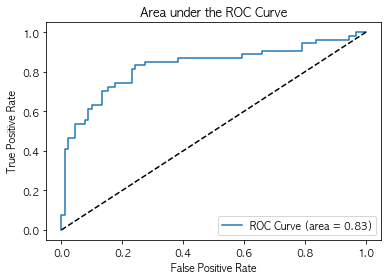

In [55]:
plt.figure()
# x축엔 Fall-out(FPR), y축엔 Recall(TPR)
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Area under the ROC Curve")
plt.legend(loc='lower right')
plt.show()

#### Random Forest

- 파라미터 설명
    * ``maxBins`` : split을 할 노드의 최대 개수
    * ``numTrees`` : ``n_estimators``
    * ``impurity``: 불순도 계산할 공식
    * ``minInstancesPerNode``: ``min_samples_split``

In [57]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

# 모델 정의
rf = RandomForestClassifier(labelCol='Survived')
paramGrid = ParamGridBuilder().addGrid(rf.maxDepth, [5, 10, 20])\
                              .addGrid(rf.maxBins, [20, 32, 50])\
                              .addGrid(rf.numTrees, [20, 40, 60])\
                              .addGrid(rf.impurity, ['gini', 'entropy'])\
                              .addGrid(rf.minInstancesPerNode, [1, 5, 10])\
                              .build()

# 교차검증 정의
tvs = TrainValidationSplit(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol='Survived'),
                          trainRatio=0.8)
# 학습
model = tvs.fit(train_df)
# 예측 - DataFrame으로 반환
model_predictions = model.transform(test_df)

acc = MulticlassClassificationEvaluator(labelCol='Survived',
                                       metricName='accuracy').evaluate(model_prediction)
pre = MulticlassClassificationEvaluator(labelCol='Survived',
                                       metricName='weightedPrecision').evaluate(model_prediction)
print("Accuracy :", acc)
print("Precision :", pre)

Accuracy : 0.7793103448275862
Precision : 0.7925739676458068


In [58]:
# Evaluate ROC metrics
# RDD 자료구조로 바꾸어 주기 위해 SparkContext 생성
sc = SparkContext.getOrCreate()

results = model_predictions.select(['probability', 'Survived'])
results_collect = results.collect()

In [60]:
# Positive로 예측될 확률값, 레이블값 담기
results_list = [(float(i.probability[1]), float(i.Survived)) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

In [61]:
# AUC 계산
metrics = metric(scoreAndLabels)
auc = metrics.areaUnderROC
print("AUC score: ", auc)

AUC score:  0.8866503866503868


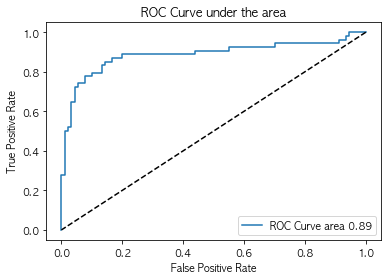

In [68]:
# Visualize ROC Curve, AUC
from sklearn.metrics import roc_curve, auc

fpr, tpr = [], []
roc_auc = []

y_test = [i[1] for i in results_list]
y_proba = [i[0] for i in results_list]

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC Curve area %0.2f' % roc_auc)
plt.plot([1, 0], [1, 0], 'k--')
plt.title("ROC Curve under the area")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()

#### Gradient Boosting Classifier

In [ ]:
from pyspark.ml.classification import GBTClassifier

# 모델정의
gbt = GBTClassifier(labelCol='Survived')
# 튜닝할 파라미터 그리드 정의
paramGrid = ParamGridBuilder().addGrid(gbt.maxDepth, [5, 10, 20])\
                              .addGrid(gbt.maxBins, [20, 32, 50])\
                              .addGrid(gbt.maxIter, [10, 20, 30])\
                              .addGrid(gbt.minInstancesPerNode, [1, 5, 10])\
                              .build()

# 교차검증 정의
tvs = TrainValidationSplit(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol='Survived'),
                          trainRatio=0.8)

# 학습
model = tvs.fit(train_df)
# 예측 - 데이터프레임으로 반환
model_predictions = model.transform(test_df)

acc = MulticlassClassificationEvaluator(labelCol='Survived',
                                       metricName='accuracy').evaluate(model_prediction)
pre = MulticlassClassificationEvaluator(labelCol='Survived',
                                       metricName='weightedPrecision').evaluate(model_prediction)
print("Accuracy :", acc)
print("Precision :", pre)

In [ ]:
sc = SprakContext.getOrCreate()

results = model_predictions.select(['probability', 'Survived'])

results_collect = results.collect()
results_list = [(float(i.probability[1]), float(i.Survived)) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

metrics = metric(scoreAndLabels)
auc = metrics.areaUnderROC
print("AUC score:", auc)

In [ ]:
# Visuallize ROC Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr = [], []
roc_auc = []

y_test = [i[1] for i in results_list]
y_proba = [i[0] for i in results_list]

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([1, 0], [1, 0], 'k--')
plt.title("ROC Curve under the area")
plt.xlabel("False Postivie Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()